<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/scRNA_seq_D1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of scRNA-seq of Etv2 induced reprogramming at D0 and D1

by Wuming Gong



Explore the diversified MEF population and see which subpopulation differentiated into HE population

In [250]:
start_time0 <- Sys.time()

### Install external packages

In [251]:
system('apt-get -q install libgsl-dev', intern = TRUE)

[1] "Reading package lists..."                                       
[2] "Building dependency tree..."                                    
[3] "Reading state information..."                                   
[4] "libgsl-dev is already the newest version (2.4+dfsg-6)."         
[5] "0 upgraded, 0 newly installed, 0 to remove and 17 not upgraded."

In [252]:
system('apt-get install libcairo2-dev', intern = TRUE) # required by R package ComplexHeatmap 

[1] "Reading package lists..."                                         
[2] "Building dependency tree..."                                      
[3] "Reading state information..."                                     
[4] "libcairo2-dev is already the newest version (1.15.10-2ubuntu0.1)."
[5] "0 upgraded, 0 newly installed, 0 to remove and 17 not upgraded."

In [253]:
system('apt-get install libudunits2-dev') # required by R package 'units'

In [254]:
system('apt-get install -y libgdal-dev libgeos-dev libproj-dev') # required by R package sf

### Install R packages

In [255]:
install.packages('BiocManager')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [256]:
required_packages <- c(
  'devtools',
  'ggplot2', 'circlize', 'ComplexHeatmap',
  'TxDb.Mmusculus.UCSC.mm10.knownGene',
  'BiocGenerics', 'DelayedArray', 'DelayedMatrixStats', 'limma', 'S4Vectors', 'SingleCellExperiment', 'SummarizedExperiment', 'batchelor', 'Matrix.utils', 'units', 'sf' # required by Monocle3
)

In [257]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

### Install Monocle3 from github

In [258]:
devtools::install_github('cole-trapnell-lab/leidenbase', force = TRUE)


✔  checking for file ‘/tmp/Rtmp7NDElG/remotes7bf230e47322/cole-trapnell-lab-leidenbase-8c52ebc/DESCRIPTION’
─  preparing ‘leidenbase’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories (494ms)
─  building ‘leidenbase_0.1.2.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [259]:
devtools::install_github('cole-trapnell-lab/monocle3', force = TRUE)

Skipping 9 packages not available: SummarizedExperiment, S4Vectors, limma, DelayedMatrixStats, DelayedArray, BiocGenerics, batchelor, SingleCellExperiment, Biobase



✔  checking for file ‘/tmp/Rtmp7NDElG/remotes7bf274c90a7c/cole-trapnell-lab-monocle3-4c01d89/DESCRIPTION’ (338ms)
─  preparing ‘monocle3’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘monocle3_0.2.3.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### Load R packages

In [260]:
library(devtools)

In [261]:
library(SummarizedExperiment)
library(RColorBrewer)
library(monocle3)
library(dplyr)
library(ggplot2)
library(Matrix)
library(circlize)
library(igraph)
library(ComplexHeatmap)

## Load processed scRNA-seq data

In [262]:
remote_rds_file <- 'https://s3.msi.umn.edu/gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds'
system(sprintf('wget -x -c -nH %s', remote_rds_file))

In [263]:
local_rds_file <- gsub('https://s3.msi.umn.edu/', './', remote_rds_file)
se <- readRDS(local_rds_file)
table(colData(se)$group)


  MEF_NoDox  MEF_Dox_D1  MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b 
       3562         948        2936        7202         827 

## Subset the cells from MEF and D1

In [264]:
se <- se[, colData(se)$group %in% c('MEF_NoDox', 'MEF_Dox_D1')]

In [265]:
table(colData(se)$group)


  MEF_NoDox  MEF_Dox_D1  MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b 
       3562         948           0           0           0 

## Trajectory analysis

In [266]:
num_pca_dim <- 50L
min_expr_cells <- 10L
k_neighbors <- 200L

In [267]:
counts <- assays(se)$counts
cell_metadata <- colData(se)
colnames(counts) <- 1:ncol(counts)
rownames(cell_metadata) <- 1:ncol(counts)
gene_metadata <- rowData(se)
rownames(counts) <- gene_metadata[, 'name']
rownames(gene_metadata) <- gene_metadata[, 'name']
gene_metadata$gene_short_name <- gene_metadata[, 'name']

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



In [268]:
x <- new_cell_data_set(counts, cell_metadata = cell_metadata, gene_metadata = gene_metadata)

In [269]:
x <- x[rowSums(assays(x)$counts > 0) >= min_expr_cells, ]

In [270]:
x <- preprocess_cds(x, method = 'PCA', num_dim = num_pca_dim)

In [271]:
x <- reduce_dimension(x, reduction_method = 'UMAP', verbose = TRUE, cores = 2L)

No preprocess_method specified, using preprocess_method = 'PCA'

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'

Running Uniform Manifold Approximation and Projection

19:19:45 UMAP embedding parameters a = 1.577 b = 0.8951

19:19:45 Read 4510 rows and found 50 numeric columns

19:19:45 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:19:46 Writing NN index file to temp file /tmp/Rtmp7NDElG/file7bf246e7f0ae

19:19:46 Searching Annoy index using 2 threads, search_k = 1500

19:19:47 Annoy recall = 100%

19:19:47 Commencing smooth kNN distance calibration using 2 threads

19:19:49 Initializing from normalized Laplacian + noise

19:19:49 Commencing optimization for 500 epochs, with

In [272]:
x <- cluster_cells(x, reduction_method = 'UMAP', k = k_neighbors)

In [273]:
x <- learn_graph(x, use_partition = FALSE)

  |======================================================================| 100%


In [274]:
x

class: cell_data_set 
dim: 13669 4510 
metadata(2): cds_version citations
assays(1): counts
rownames(13669): Mrpl15 Lypla1 ... CAAA01118383.1 CAAA01147332.1
rowData names(7): id name ... clusters gene_short_name
colnames(4510): 1 2 ... 4509 4510
colData names(8): barcodes group ... cluster Size_Factor
reducedDimNames(2): PCA UMAP
altExpNames(0):

## Plot the trajectories

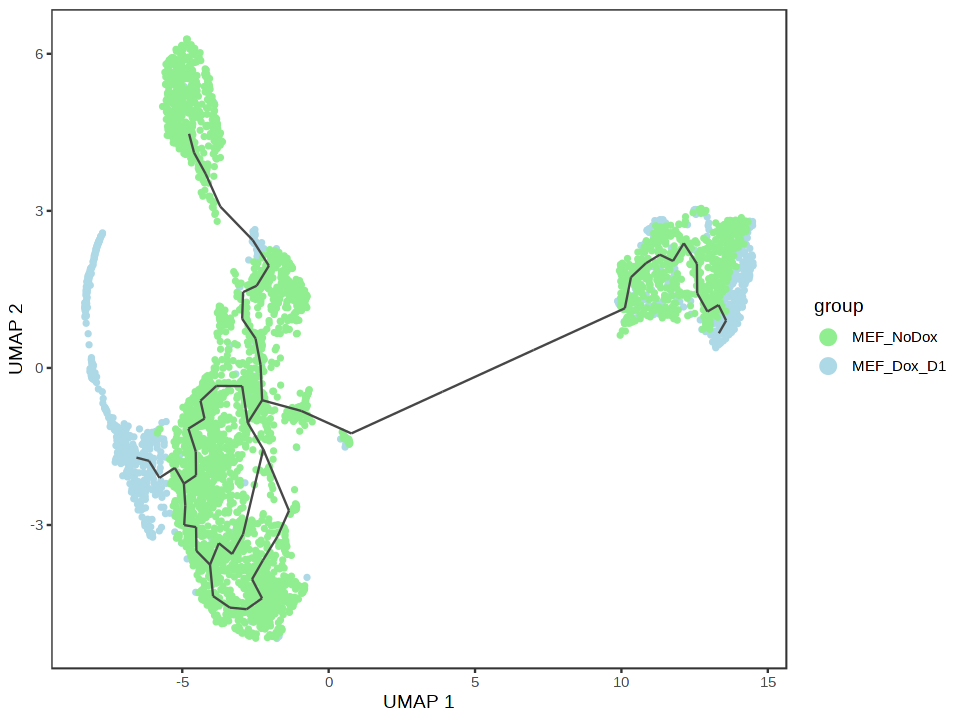

In [275]:
options(repr.plot.width = 8, repr.plot.height = 6)
plot_cells(
  x, 
  label_groups_by_cluster = FALSE,  
  color_cells_by = "group", 
  group_label_size = 4,
  show_trajectory_graph = TRUE,
  label_cell_groups = FALSE,
  label_roots = FALSE,
  label_leaves = FALSE,
  label_branch_points = FALSE,
  trajectory_graph_segment_size = 0.5,
  cell_size = 1,
) + scale_color_manual(
    values = c(
      "MEF_NoDox" = "lightgreen", 
      "MEF_Dox_D1" = "lightblue"
    ),
    name = 'group'
  ) +
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

## Determine the center vertices of each cell type

In [276]:
groups <- unique(colData(x)$group)
CT <- sparseMatrix(
  i = 1:ncol(x),
  j = as.numeric(factor(colData(x)$group, groups)),
  dims = c(ncol(x), length(groups)),
  dimnames = list(NULL, groups)
) # cell id ~ cell type

In [277]:
CV <- sparseMatrix(
  i = 1:ncol(x),
  j = x@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex,
  dims = c(ncol(x), max(x@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex))
) # cell ~ vertex

In [278]:
VT <- as(t(CV), 'dgCMatrix') %*% CT # vertex ~ cell type

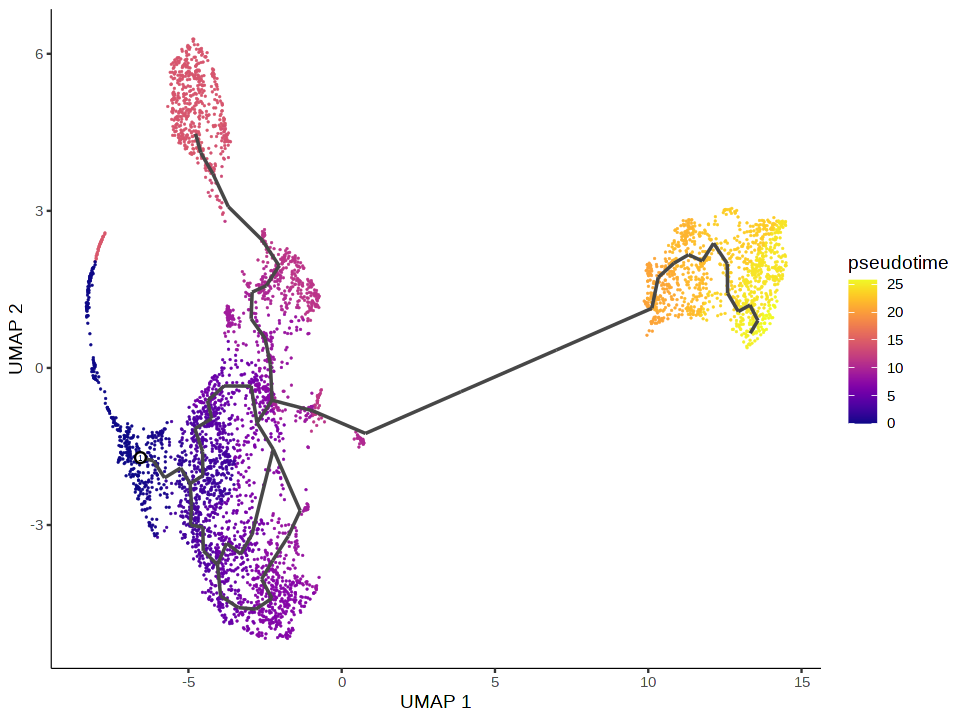

In [279]:
C1_center <- order(VT[, 'MEF_Dox_D1'], decreasing = TRUE)[1]
x <- order_cells(x, root_pr_nodes = sprintf('Y_%d', C1_center))
options(repr.plot.width = 8, repr.plot.height = 6)
plot_cells(
  x,
  color_cells_by = "pseudotime",
  label_cell_groups=FALSE,
  label_leaves=FALSE,
  label_branch_points=FALSE,
  graph_label_size=1.5
)

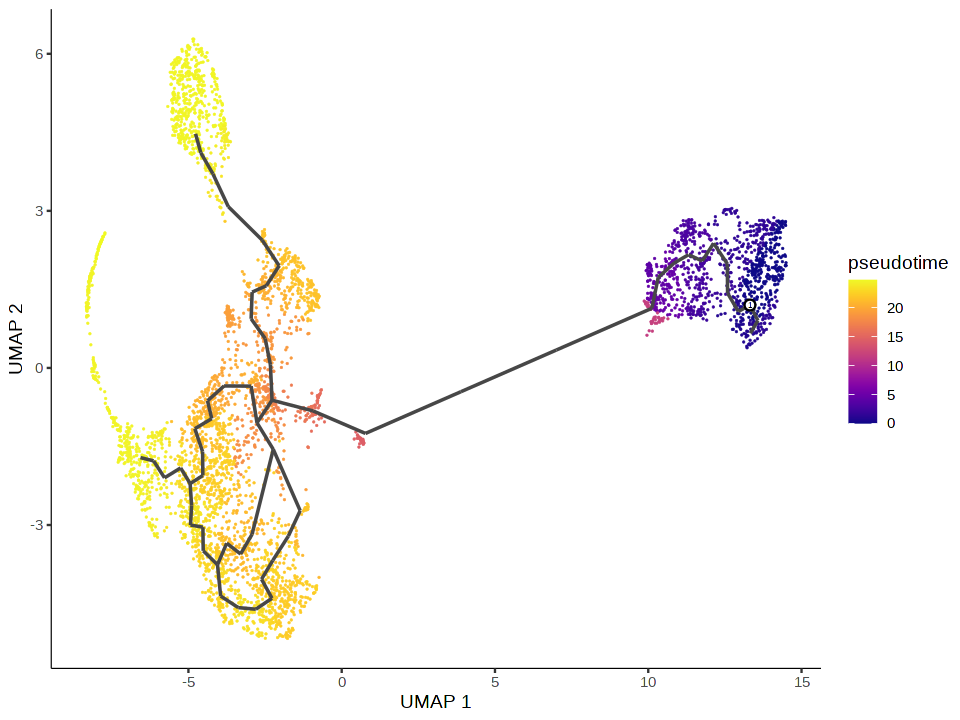

In [280]:
C2_center <- order(VT[, 'MEF_Dox_D1'], decreasing = TRUE)[2]
x <- order_cells(x, root_pr_nodes = sprintf('Y_%d', C2_center))
options(repr.plot.width = 8, repr.plot.height = 6)
plot_cells(
  x,
  color_cells_by = "pseudotime",
  label_cell_groups=FALSE,
  label_leaves=FALSE,
  label_branch_points=FALSE,
  graph_label_size=1.5
)

## Find the shortest pathway between cell types

In [281]:
graph <- x@principal_graph_aux[["UMAP"]]$stree %>% 
  graph.adjacency() # graph of vertices only

In [282]:
path <- shortest_paths(graph, from = C1_center, to = C2_center)$vpath[[1]] %>%
  as.numeric()

Remove the vertices that have no associated cells

In [283]:
path <- path[colSums(CV[, path] ) > 0]

## Calculate the aggregated normalized counts for each vertex along the path

In [284]:
x_path <- log(assays(x)$counts + 1) %*% CV[, path] %*% Diagonal(x = 1 / (colSums(CV[, path]) +1 ))

## Find the genes that are significantly up-regulated in each of three trajectories

In [285]:
res <- do.call('rbind', lapply(1:nrow(x_path), function(i){
  mod <- lm(
    y ~ pseudotime, 
    data.frame(
      y = x_path[i, ],
      pseudotime = 1:ncol(x_path)
    )
  )
  coef(summary(mod))[2, c(1, 4)]
}))

In [286]:
rownames(res) <- rownames(x_path)

In [287]:
res_top <- res %>% 
  as.data.frame() %>%
  filter(Estimate > 0) %>%
  arrange(`Pr(>|t|)`) %>% 
  head(10)
res_top

,Estimate,Pr(>|t|)
,<dbl>,<dbl>
Psmc5,0.0199059311,0.003778008
Etfb,0.0160377615,0.003824109
Cops6,0.0241686442,0.004814933
Cope,0.0106676139,0.006397893
Acy1,0.0013744756,0.010456812
Prmt1,0.0294123128,0.013145348
Acot10,0.0005293154,0.013650497
Fdps,0.0093418268,0.020296699
Nthl1,0.0015615180,0.023108444


In [288]:
res_bottom <- res %>% 
  as.data.frame() %>%
  filter(Estimate < 0) %>%
  arrange(`Pr(>|t|)`) %>% 
  head(10)
res_bottom

,Estimate,Pr(>|t|)
,<dbl>,<dbl>
Ylpm1,-0.02955021,6.458971e-15
Prrc2c,-0.07403798,1.057186e-14
Tmem245,-0.03952889,3.510028e-14
Phip,-0.03582109,4.242656e-14
Ly6e,-0.05623937,5.423112e-14
Sypl,-0.04267287,6.627477e-14
Ankrd11,-0.05477586,6.747071e-14
Gclc,-0.02627629,7.007112e-14
Zfhx4,-0.03612209,7.694440e-14


In [291]:
y <- x_path[c(rownames(res_top), rownames(res_bottom), 'Kdr'), ] %>% 
  as.matrix() %>% 
  t() %>%
  scale() %>%
  t()

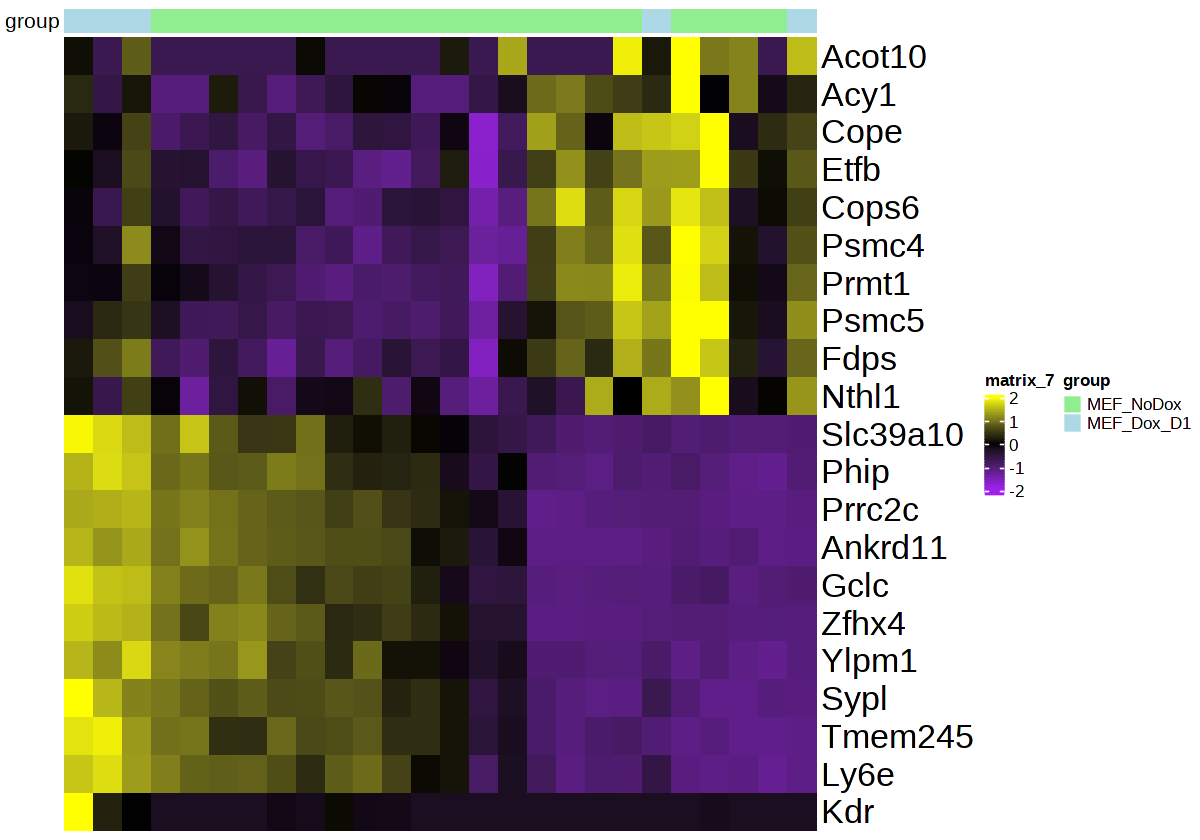

In [292]:
options(repr.plot.width = 10, repr.plot.height = 7)
col_fun <- colorRamp2(c(-2, 0, 2), c("purple", "black", "yellow"))
column_annotation <-  columnAnnotation(
  group = colData(x)$group[CV[, path] %>% t() %>% max.col()],
  col = list(
    group = c(
      "MEF_NoDox" = "lightgreen", 
      "MEF_Dox_D1" = "lightblue"
    )
  ),
  show_legend = TRUE,
  annotation_name_side = 'left'
)
Heatmap(
  y,
  cluster_rows = TRUE,
  cluster_columns = FALSE,
  show_column_dend = FALSE,
  show_row_dend = FALSE,
  show_column_names = FALSE,
  show_row_names = TRUE,
  col = col_fun,
  row_names_gp = gpar(fontsize = 20),
  top_annotation = column_annotation
) 

## Pathway analysis